### フラックスバランス解析について

このnotebookではフラックスバランス解析の解説はしないので、適宜以下の文章などを参照

What is flux balance analysis?

https://www.nature.com/articles/nbt.1614

代謝シミュレーションによる細胞内代謝のデザインと工学的応用

https://www.sbj.or.jp/wp-content/uploads/file/sbj/9211/9211_tokushu_2.pdf

大阪大学　清水浩研究室のHP

https://metabolic-engineering.jp/page/research/2

システム生物学入門（第III部）（12/1出版）

https://amzn.to/3uidGhu

なお、このチュートリアルコードはかなりの部分がopenCOBRAドキュメント

https://opencobra.github.io/

の和訳なので、分からないところがあれば本家を参照



### FBAでやっていること
フラックスバランス解析（以下FBA）では、細胞の代謝状態のダイナミクスが
$$\frac{d{\bm x}}{dt}=S{\bm v}$$
と書かれ、定常状態で
$$S{\bm v}={\bm 0}$$
となることを利用し、定常状態における代謝フラックスを予測する。ただしここで${\bm x},{\bm v},S$はそれぞれ代謝物質濃度ベクトル、代謝流束ベクトル、化学量論係数行列である。



$$S{\bm v}={\bm 0}$$

より、定常状態における流束フラックス（以下、定常フラックス）は$\ker S$の元である。ただし$\ker S$というのは線形部分空間で、$\dim \ker S>0$である限り定常フラックスの取り方は無限にある。

そのため、FBAでは各反応の上限・下限値を設定し、その条件下で何らかのフラックスの定常値（大抵は菌体合成反応）を最大化することで定常フラックスの予測を行う。




### 何ができるのか

実際にどのようなことができるのかは、

Escher-FBA

https://sbrg.github.io/escher-fba/#/

でいろいろ遊んでみるとイメージがつくと思う。これは代謝ネットワーク可視化パッケージであるEscherとFBAを組み合わせたもので、GUIで各フラックスの上限・下限などを変えることができる。

たとえば図の右上の方にある「EX_o2_e」の下限値をゼロにしてみよ。これは細胞培養環境を嫌気環境にすることに対応する（酸素の供給がなくなる）ため、大きく代謝状態が変化することが分かる。他にも色々と試してみよ。

以下でやることを大雑把に説明すれば、Escher-FBAでやっていること（代謝フラックスの上限・下限を色々と変化させることで定常代謝状態の変化を調べる）を、CUIでよりシステマチックにやる方法の解説である。


###　必要な計算環境の準備

FBAはより一般的には The COnstraints Based Reconstruction and Analysis というものの一種で、略してCOBRAという。FBAを実行するために必要なパッケージがMATLABとpython用に作られているが、MATLABは有償（東大だとキャンパスワイドライセンスがあるがそういうものは日本だとむしろ稀なので）、言語はpythonを使う（python記法は知っていると仮定する。知らない場合は適宜Googleなり、ChatGPTに聞いてほしい）。最近Julia向けにもできた。

python用に開発されたCOBRAツールキットであるCOBRApy

https://opencobra.github.io/cobrapy/

の"Installation"に従ってCOBRApyをインストールする（condaでやってくれてもpipでやってくれてもどちらでも良い）




In [89]:
#pip install markupsafe==2.0.1


パッケージをインポート

In [90]:
import cobra
#import escher
from cobra.io import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
cobra_config = cobra.Configuration()
cobra_config.solver = "glpk"

モデルをロード（Escherで示されたモデルと同じ、小さめのモデル）
最大化する目的関数は菌体合成反応(Biomass_Ecoli_core)になっている

In [92]:
model = load_model("textbook")
model

Name,e_coli_core
Memory address,28f05b7f0
Number of metabolites,72
Number of reactions,95
Number of genes,137
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


すべての反応の上限・下限を確認

In [93]:
# list the name of reactions and the upper and lower bounds
vlim = pd.DataFrame([[reaction.id, reaction.lower_bound, reaction.upper_bound] for reaction in model.reactions])
vlim = pd.DataFrame([[reaction.id, reaction.lower_bound, reaction.upper_bound] for reaction in model.reactions], columns=['Reaction', 'vmax', 'vmin']).set_index('Reaction')

# chenge how may rows are displayed
pd.set_option('display.max_rows', 100)
vlim


,vmax,vmin
Reaction,,
ACALD,-1000.00,1000.0
ACALDt,-1000.00,1000.0
ACKr,-1000.00,1000.0
ACONTa,-1000.00,1000.0
ACONTb,-1000.00,1000.0
ACt2r,-1000.00,1000.0
ADK1,-1000.00,1000.0
AKGDH,0.00,1000.0
AKGt2r,-1000.00,1000.0


デフォルトの設定でフラックスバランス解析をやってみる


In [94]:
solution = model.optimize()

# 最適化結果を表示
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


## 代謝フラックスの可視化

ここでは最適化の結果どのようなフラックス分布が取られるようになったか可視化する
可視化にはescherというパッケージを使う

In [95]:
import escher
from escher import Builder

In [96]:
# 警告を非表示
escher.rc['never_ask_before_quit'] = True

In [97]:
# マップの設定
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    model_name='e_coli_core',
)
# マップに定常フラックスデータを追加
builder.reaction_data = solution.fluxes
# 表示
builder


Builder(never_ask_before_quit=True, reaction_data={'ACALD': 0.0, 'ACALDt': 0.0, 'ACKr': 3.1922147150048876e-14…

## 反応上限・下限の変更

モデルの設定を変えた場合にどうなるかをみる。

まずは「生きていく」ために必要なATPの消費（ATPM）の下限（最低限これだけ消費せよ、という量）を10倍にしてみる

In [98]:
model.reactions.ATPM.lower_bound = 10*model.reactions.ATPM.lower_bound

ATPMの下限を10倍にした結果、成長速度が半分になった

In [99]:
solution = model.optimize()

# 最適化結果を表示
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,2.638,0,0.00%
o2_e,EX_o2_e,38.85,0,0.00%
pi_e,EX_pi_e,1.78,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-39.41,1,100.00%
h2o_e,EX_h2o_e,-42.93,0,0.00%
h_e,EX_h_e,-9.706,0,0.00%


ATPMの下限値を連続的に変えながら成長速度を計算し、成長速度のATPM下限値依存性をプロット

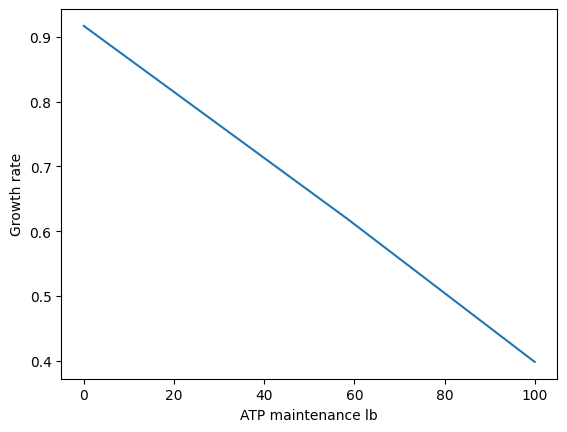

In [100]:
growth = []
for vmin in np.linspace(0,100,100):
    model.reactions.ATPM.lower_bound = vmin
    solution = model.optimize()
    growth.append(solution.objective_value)

plt.plot(np.linspace(0,100,100), growth)
plt.xlabel('ATP maintenance lb')
plt.ylabel('Growth rate')
plt.show()


## 培地の栄養源を変える（デフォルトではグルコース）

まずは栄養条件を確認する。


In [101]:
# 一度モデルを初期化
model = load_model("textbook")

In [102]:
model.medium

{'EX_co2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0}

初期設定ではグルコースが栄養源として供給されているので、これを酢酸に変えてみる

In [103]:
medium = model.medium.copy()
medium_original = model.medium.copy() # medium_original は以降のために保存しておく
medium["EX_glc__D_e"] = 0.0
medium["EX_ac_e"] = 10.0
model.medium = medium
# 確認
model.medium

{'EX_ac_e': 10.0,
 'EX_co2_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0}

In [104]:
# 最適化
solution = model.optimize()
# 結果を表示
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,10,2,100.00%
h_e,EX_h_e,6.523,0,0.00%
nh4_e,EX_nh4_e,0.9452,0,0.00%
o2_e,EX_o2_e,12.42,0,0.00%
pi_e,EX_pi_e,0.6377,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-12.62,1,100.00%
h2o_e,EX_h2o_e,-13.89,0,0.00%


In [105]:
# 代謝マップで表示
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    model_name='e_coli_core',
)
builder.reaction_data = solution.fluxes
builder

Builder(never_ask_before_quit=True, reaction_data={'ACALD': 0.0, 'ACALDt': 0.0, 'ACKr': 10.000000000000004, 'A…

酸素の取り込みを不可能にしてみる

In [106]:
medium = medium_original
medium['EX_o2_e'] = 0.0
model.medium = medium

In [107]:
# 最適化
solution = model.optimize()
# 結果を表示
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,0.3782,1,0.63%
glc__D_e,EX_glc__D_e,10,6,99.37%
h2o_e,EX_h2o_e,7.116,0,0.00%
nh4_e,EX_nh4_e,1.154,0,0.00%
pi_e,EX_pi_e,0.7786,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,-8.504,2,33.11%
etoh_e,EX_etoh_e,-8.279,2,32.23%
for_e,EX_for_e,-17.8,1,34.66%
h_e,EX_h_e,-30.55,0,0.00%


In [108]:
# 代謝マップで表示
builder = Builder(
    map_name='e_coli_core.Core metabolism',
    model_name='e_coli_core',
)
builder.reaction_data = solution.fluxes
builder

Builder(never_ask_before_quit=True, reaction_data={'ACALD': -8.27945538048657, 'ACALDt': 1.5948213258617017e-1…

## 他のモデルでやってみる
フラックスバランス解析をおこなうためのモデルはtextbookモデル（e_coli_coreモデル）のみではない。より巨大な代謝ネットワークをモデル化したものがいくつも提案されており、その一部は

BiGGデータベース

http://bigg.ucsd.edu/

で集中管理されている（大腸菌だけでなく、ヒトも含めた様々な生物種のモデルがある。見てみると良いかも知れない）

ここではより大きな大腸菌の代謝モデルであるiJO1366を使ってみよう

In [109]:
model = load_model("iJO1366")

In [110]:
model

Name,iJO1366
Memory address,28e0829a0
Number of metabolites,1805
Number of reactions,2583
Number of genes,1367
Number of groups,37
Objective expression,1.0*BIOMASS_Ec_iJO1366_core_53p95M - 1.0*BIOMASS_Ec_iJO1366_core_53p95M_reverse_5c8b1
Compartments,"cytosol, extracellular space, periplasm"


In [111]:
solution = model.optimize()
# 最適化結果を表示
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.005113,0,0.00%
cl_e,EX_cl_e,0.005113,0,0.00%
cobalt2_e,EX_cobalt2_e,2.456E-05,0,0.00%
cu2_e,EX_cu2_e,0.0006965,0,0.00%
fe2_e,EX_fe2_e,0.01578,0,0.00%
glc__D_e,EX_glc__D_e,10,6,100.00%
k_e,EX_k_e,0.1918,0,0.00%
mg2_e,EX_mg2_e,0.008522,0,0.00%
mn2_e,EX_mn2_e,0.0006788,0,0.00%
mobd_e,EX_mobd_e,0.0001267,0,0.00%


### 最適化の結果を可視化してみる
(微妙にcobraモデルの反応名とescherモデルの反応名が一致しなくて合っていない部分がある)

In [113]:
builder.map_name = 'iJO1366.Central metabolism'

In [116]:
builder.reaction_data = solution.fluxes
builder

Builder(allow_building_duplicate_reactions=False, and_method_in_gene_reaction_rule='mean', cofactors=['atp', '…

## 練習問題
iJO1366について、e_coli_coreに行った解析と同様の解析を行ってみよ